GaussianDyBM Time-series Prediction Demo
========================================

- Author: Sakyasingha Dasgupta (sdasgup@jp.ibm.com)

- Date: Sep 27, 2016.

- (C) Copyright IBM Corp. 2016

Similar to other DyBM models, the Gaussian DyBM can be trained online for learning the generative model of given time-series patterns, and can be then used to predict future values of the time series. Unlike the standard binary DyBM, the Gaussian DyBM (G-DyBM) can model real-values time series data. 

Mathematical description
------------------------
In the standard G-DyBM the conditional probability density of any time-series vector $\mathbf{X}^{[t]}$ given $\mathbf{X}^{[t-T, t-1]}$ is represented as: 

$p(\mathbf{X}^{[t]} | \mathbf{X}^{[t-T, t-1]}) = \prod_{j=1}^N p_j(X_j^{[t]} | \mathbf{X}^{[t-T, t-1]})$, 

Where, it assumes that $X_j^{[t]}$ has a Gaussian distribution for each $j$ with mean $\mu_j$ and standard deviation $\sigma_j$, such that: $p(X_j^{[t]} | \mathbf{X}^{[t-T, t-1]})  = \frac{1}{\sqrt{2\pi\sigma_j^2}}exp\Big(-\frac{(X_j^{[t]} - \mu_j^{[t]})^2}{\sigma_j^2}\Big)$. 

In order to make prediction of the future values of the time-series, we use the mean of the distribution $\mu_j^{[t]}$. This is updated based on the parameters of the $N$-dimensional G-DyBM (weight and bias) and can be interpreted as the expected value of the $j$-th unit at time $t$ given the last $T$ patterns. For $T\rightarrow\infty$ it can be written as: 

$\mu_j^{[t]} = b_j + \sum_{i=1}^{N}\sum_{\delta=1}^{d_{ij}-1}w_{ij}^{[\delta]}X_i^{[t-\delta]} + \sum_{i=1}^{N} \sum_{k=1}^{K}u_{ijk}\alpha_{ijk}^{[t-1]}$

Here, $d_{ij}$ is the maximum delay between units and $\alpha_{ijk}^{[t-1]}$ is the eligibility trace updated recursively with decay rate $\gamma_k$ as, $\alpha_{ijk}^{[t]} = \gamma_k\alpha_{ijk}^{[t-1]}  + X_i^{[t-d_{ij}+1]}$.

For further model details see:
[1] S.Dasgupta & T. Osogami, Nonlinear Dynamic Boltzmann Machine for Time-series Prediction (in submission)

Model descriptions and initialization
-------------------------------------
G-DyBM has the following two memory units, and uses them to predict the next time-series pattern.

- queue stores raw patterns

- eligibility traces store some statistics of all the previous patterns. If we use `insert_to_etrace="w_delay"`, a pattern popped from the queue will be inserted to eligibility traces (thus delayed by `delay`), and if we use `insert_to_etrace="wo_delay"`, a pattern enqueued to the queue is also inserted into eligibility traces.

G-DyBM can be initialized using the following parameters:

- `in_dim` is the dimension of the input time-series patterns $\mathbf{X}$.

- `out_dim` is the dimension of the expected output time-series patterns

- `delay` determines the length of the queue (which will be `delay`-1).

- `decay_rates` is a list of eligibility traces' parameters.

- `SGD` decides the type of stochastic gradient descent optimization to use. Options: AdaGrad (default), AdaGradPlus, RMSProp and ADAM.

- `L1` specifies the strength of L1 regularization. (defaults to zero)

- `L2` specifies the strength of L1 regularization. (defaults to zero)

- `insert_to_etrace` determines the definition of eligibility traces, as discussed above

- `learning_rate` sets the learning rate of SGD.

Example
-------
In this simple example, we show how to use the G-DyBM in order to a model and predict the next pattern in a noisy sine wave. The noisy sine wave can be easily generated by importing from $\textbf{pydybm.base.generator}$. We train G-DyBM in an online manner and evaluate the prediction performance using the root mean squared error (RMSE) between the predicted pattern and the actual time-series.

This setup can be easily extended to try other DyBM models.


Learning epoch RMSE : 0.38110
Learning epoch RMSE : 0.14806
Learning epoch RMSE : 0.15355
Learning epoch RMSE : 0.14921
Learning epoch RMSE : 0.14504
Learning epoch RMSE : 0.14785
Learning epoch RMSE : 0.14427
Learning epoch RMSE : 0.14629
Learning epoch RMSE : 0.15484
Learning epoch RMSE : 0.15047


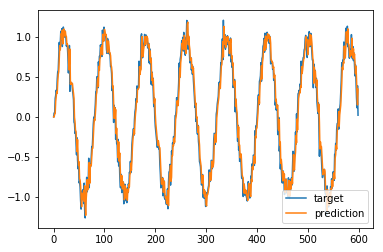

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pydybm.time_series.rnn_gaussian_dybm import GaussianDyBM
from pydybm.base.generator import NoisySin
from pydybm.base.sgd import RMSProp
from sklearn.metrics import mean_squared_error
import numpy as np

def MSE(y_true,y_pred):
    """
    Function to calculate the mean squared error of a sequence of predicted vectors
    
    y_true : array, shape(L,N)
    y_pred : array, shape(L,N)

    mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors (y_true[i],y_pred[i])
    """
    MSE_each_coordinate = mean_squared_error(y_true,y_pred,multioutput="raw_values")
    return np.sum(MSE_each_coordinate)

def RMSE(y_true,y_pred):
    """
    Function to calculate the root mean squared error of a sequence of predicted vectors
    
    y_true : array, shape(L,N)
    y_pred : array, shape(L,N)

    squared root of the mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors (y_true[i],y_pred[i])
    """
    return np.sqrt(MSE(y_true,y_pred))

# Prepare a generator of noisy sine wave time-series
length = 600  # length of the time-series
period = 80   # period of the sine wave
std = 0.1     # standard deviation of the noise
dim = 1       # dimension of the time-series
timeSeries = NoisySin(length,period,std,dim)

max_iter = 10  #maximum number of learning epochs/iterations to run
SGD = RMSProp #setting the SGD optimization method 

#setting DyBM hyperparameters
delay = 2
decay = 0.3
learning_rate = 0.001


# Create and initialize a Gaussian DyBM
dybm = GaussianDyBM(dim,delay=delay,decay_rates=[decay], SGD=SGD())
dybm.set_learning_rate(learning_rate)

#training the Gaussian DyBM
for i in range(max_iter):
    #initialize the memory units in DyBM
    dybm.init_state() 
    #reset the noisey sine wave time series data
    timeSeries.reset(i)
    #learn the time-series patterns and return the predicted and actual data
    result= dybm.learn(timeSeries, get_result=True)
    #calculate the prediction error
    error = RMSE(result["actual"],result["prediction"])
    print ('Learning epoch RMSE : %.5f' %(error))

# Plot the time-series and prediction 

plt.plot(result["actual"],label="target")
plt.plot(result["prediction"],label="prediction")
plt.legend()

